In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar

In [2]:
mask = pd.read_csv("../raw_data/mask-use-by-county.csv")
cases = pd.read_csv("../raw_data/RAW_us_confirmed_cases.csv")
mandate = pd.read_csv("../raw_data/U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv")

### I will find when mask mandate started in Bernalillo County, NM. Mask mandate did not change in Bernalillo County since it came out. 

In [3]:
mandate = mandate[(mandate['County_Name'] == 'Bernalillo County') & (mandate['State_Tribe_Territory'] == "NM")]
mandate

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
472550,NM,Bernalillo County,35,1,4/20/2020,2,NaN,NaN,NaN,NaN
472589,NM,Bernalillo County,35,1,4/21/2020,2,NaN,NaN,NaN,NaN
472983,NM,Bernalillo County,35,1,4/22/2020,2,NaN,NaN,NaN,NaN
473220,NM,Bernalillo County,35,1,4/23/2020,2,NaN,NaN,NaN,NaN
473335,NM,Bernalillo County,35,1,4/24/2020,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1267665,NM,Bernalillo County,35,1,8/11/2021,1,Yes,Official,NaN,"N.M. Health Order (July 30, 2021)"
1267666,NM,Bernalillo County,35,1,8/12/2021,1,Yes,Official,NaN,"N.M. Health Order (July 30, 2021)"
1267667,NM,Bernalillo County,35,1,8/13/2021,1,Yes,Official,NaN,"N.M. Health Order (July 30, 2021)"
1267668,NM,Bernalillo County,35,1,8/14/2021,1,Yes,Official,NaN,"N.M. Health Order (July 30, 2021)"


In [4]:
mandate_date = mandate[mandate.Face_Masks_Required_in_Public == "Yes"]["date"].iloc[0]
mandate_date

'5/15/2020'

### I find the covid total cases that pertains to Bernalillo County, NM.

In [5]:
cases = cases[(cases.Admin2 == "Bernalillo") & (cases.Province_State == "New Mexico")]
cases

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/18/21,10/19/21,10/20/21,10/21/21,10/22/21,10/23/21,10/24/21,10/25/21,10/26/21,10/27/21
1867,New Mexico,Bernalillo,84035001,US,USA,840,35001.0,US,35.051636,-106.670355,...,74239,74408,74523,74806,75035,75035,75035,75623,75770,75987


### I find the mask compliance data that pertains to Bernalillo County, NM.

In [6]:
mask = mask[mask.COUNTYFP == 35001]
mask

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
1795,35001,0.036,0.014,0.057,0.135,0.758


### Now we will pivot the total cases table. As the reporting spikes on Mondays and ebbs on Sundays due to reporting practices, I will smooth the total case numbers using a rolling window function and find the mean of the 7 day average.
### Also, I will calculate the difference between consecutive days to find the new cases for each day. As a result of the smoothing function, new cases will now also be smoother.

In [7]:
total_cases = cases.T.iloc[11:]

In [8]:
total_cases = total_cases.rename(columns = {1867:"covid_cases"})

In [9]:
total_cases = total_cases.rolling(window=7).mean().round()
smoothed_new_cases = total_cases["covid_cases"].diff()
smoothed_new_cases = smoothed_new_cases['2/1/20':'10/15/21']
smoothed_new_cases

2/1/20        0.0
2/2/20        0.0
2/3/20        0.0
2/4/20        0.0
2/5/20        0.0
            ...  
10/11/21    116.0
10/12/21    168.0
10/13/21    166.0
10/14/21    163.0
10/15/21    156.0
Name: covid_cases, Length: 623, dtype: float64

### I assume that covid has a 10-day infection window. Therefore, I sum up the new cases for a 10 day window.

In [10]:
ten_day_new = smoothed_new_cases.rolling(window=10).sum()

### According to [Wikipedia](https://en.wikipedia.org/wiki/Infection_rate),  infection rate = $\dfrac{the\ number\ of\ infections}{the\ number\ of\ those\ at\ risk\ of\ infection}$

### I will calculate the denominator using the total number of population minus the number of people who already had covid.

In [11]:
population = 679121 #https://en.wikipedia.org/wiki/Bernalillo_County,_New_Mexico

In [12]:
total_cases["at_risk_population"] = np.repeat(population, len(total_cases)) - total_cases["covid_cases"]

In [13]:
total_cases["infection_rate"] = ten_day_new / total_cases.at_risk_population
total_cases = total_cases.reset_index()

In [14]:
total_cases["date"] = total_cases["index"]
total_cases["date"] = pd.to_datetime(total_cases.date)

In [15]:
total_cases

,index,covid_cases,at_risk_population,infection_rate,date
0,1/22/20,NaN,NaN,NaN,2020-01-22
1,1/23/20,NaN,NaN,NaN,2020-01-23
2,1/24/20,NaN,NaN,NaN,2020-01-24
3,1/25/20,NaN,NaN,NaN,2020-01-25
4,1/26/20,NaN,NaN,NaN,2020-01-26
...,...,...,...,...,...
640,10/23/21,74559.0,604562.0,NaN,2021-10-23
641,10/24/21,74726.0,604395.0,NaN,2021-10-24
642,10/25/21,74924.0,604197.0,NaN,2021-10-25
643,10/26/21,75118.0,604003.0,NaN,2021-10-26


### This is the graph for Assignment A4. On this graph, I plotted infection rate since January 2020 and the start of the mask mandate for Bernalillo County, NM.

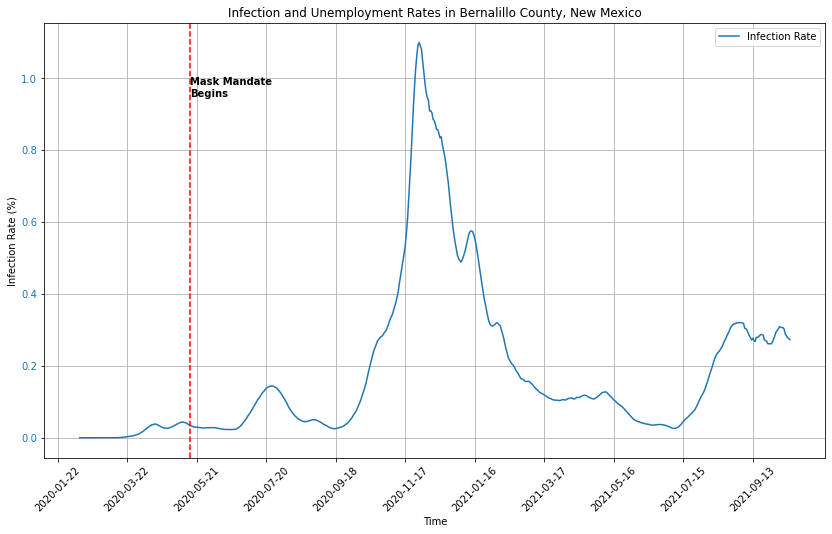

In [16]:
fig, ax1 = plt.subplots(figsize=(14,8))
color = "tab:blue"
plt.plot(total_cases.date, total_cases.infection_rate*100, label="Infection Rate", color = color)
ax1.tick_params(axis='y', labelcolor=color)
plt.grid()
plt.xticks(total_cases.date[::60],  rotation=45)
plt.ylabel("Infection Rate (%)")
plt.xlabel("Time")
plt.title("Infection and Unemployment Rates in Bernalillo County, New Mexico")
plt.axvline(x=pd.to_datetime(mandate_date, format="%m/%d/%Y"), color='r', linestyle="--")
plt.text(pd.to_datetime(mandate_date, format="%m/%d/%Y"), .95, "Mask Mandate \nBegins", fontweight="bold")
plt.legend(loc="upper right")
plt.savefig('../graph/covid_infection_rate', bbox_inches = 'tight')
plt.show()

### Now I will read in the employment data.

In [17]:
labor_df = pd.read_csv('../raw_data/BLS_Alberquerque.csv')
labor_df.head()

,Year,Period,labor force,employment,unemployment,unemployment rate
0,2020,Jan,440332,419430,20902,4.7
1,2020,Feb,442706,422131,20575,4.6
2,2020,Mar,437598,415614,21984,5.0
3,2020,Apr,414535,371514,43021,10.4
4,2020,May,414464,371736,42728,10.3


### Employment data is collected monthly and the time is in the Year and Period column. In order to merge with the covid data, I will create a new column named as "time" to depict the time.

In [18]:
labor_df['time'] = labor_df['Period'] + "/" + labor_df['Year'].astype(str)
labor_df.time = pd.to_datetime(labor_df.time, format='%b/%Y') + pd.tseries.offsets.MonthEnd(1)
labor_df.head()

,Year,Period,labor force,employment,unemployment,unemployment rate,time
0,2020,Jan,440332,419430,20902,4.7,2020-01-31
1,2020,Feb,442706,422131,20575,4.6,2020-02-29
2,2020,Mar,437598,415614,21984,5.0,2020-03-31
3,2020,Apr,414535,371514,43021,10.4,2020-04-30
4,2020,May,414464,371736,42728,10.3,2020-05-31


### One of the assumptions of Granger Causality test is stationarity. Covid and employment data are not stationary but I will find the first discrete difference, i.e. the difference between consecurtive periods, of the time series, the data would be stationary. 

### As the employment data is monthly, I will also calculate monthly new covid cases data by subtracting previous month's total cases from the current month's. After the new monthly covid cases are calculated, I will take the first discrete difference of the time series to ensure staionarity.

In [19]:
covid = total_cases.set_index("date")
covid_monthly_new_cases = covid.loc[labor_df.time[1:]]['covid_cases'].diff()
covid_monthly_new_cases.head()

date
2020-02-29      NaN
2020-03-31     82.0
2020-04-30    635.0
2020-05-31    699.0
2020-06-30    604.0
Name: covid_cases, dtype: float64

### We will fill the first month's (Feb 2020) covid cases as 0.

In [20]:
covid_monthly_new_cases = covid_monthly_new_cases.fillna(0)
covid_monthly_new_cases.head()

date
2020-02-29      0.0
2020-03-31     82.0
2020-04-30    635.0
2020-05-31    699.0
2020-06-30    604.0
Name: covid_cases, dtype: float64

In [21]:
covid_monthly_infection_diff = covid_monthly_new_cases.diff().fillna(0).rename("covid_monthly_infection_diff")
covid_monthly_infection_diff

date
2020-02-29       0.0
2020-03-31      82.0
2020-04-30     553.0
2020-05-31      64.0
2020-06-30     -95.0
2020-07-31    1916.0
2020-08-31   -1325.0
2020-09-30    -468.0
2020-10-31    3723.0
2020-11-30    9673.0
2020-12-31     655.0
2021-01-31   -6079.0
2021-02-28   -4973.0
2021-03-31   -1460.0
2021-04-30    -165.0
2021-05-31    -328.0
2021-06-30   -1086.0
2021-07-31     646.0
2021-08-31    3783.0
2021-09-30      -6.0
Name: covid_monthly_infection_diff, dtype: float64

### I will now treat employment data for stationarity by calculating the marginal monthly difference in the number of the unemployed and the labor force.

In [22]:
labor_df['unemployment_diff'] = labor_df["unemployment"].diff()
labor_df['labor_force_diff'] = labor_df['labor force'].diff()

In [23]:
df_test = labor_df.merge(covid_monthly_infection_diff, right_on='date', left_on="time").dropna()

In [29]:
df_test.to_csv('../cleaned_data/final_data_testing.csv')

### Now the data is ready for the Granger Causality test. Granger Causality test code is sourced [here](https://rishi-a.github.io/2020/05/25/granger-causality.html).


In [24]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag = 5
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df


In [25]:
grangers_causation_matrix(df_test, variables = 
                          ['labor_force_diff', 'unemployment_diff', "covid_monthly_infection_diff"])

,labor_force_diff_x,unemployment_diff_x,covid_monthly_infection_diff_x
labor_force_diff_y,1.0,0.0000,0.1474
unemployment_diff_y,0.0,1.0000,0.6098
covid_monthly_infection_diff_y,0.0,0.0079,1.0000


### The test statistics seem counterintuitive and I hope to find some answers by plotting the labor force and the unemployment rate.

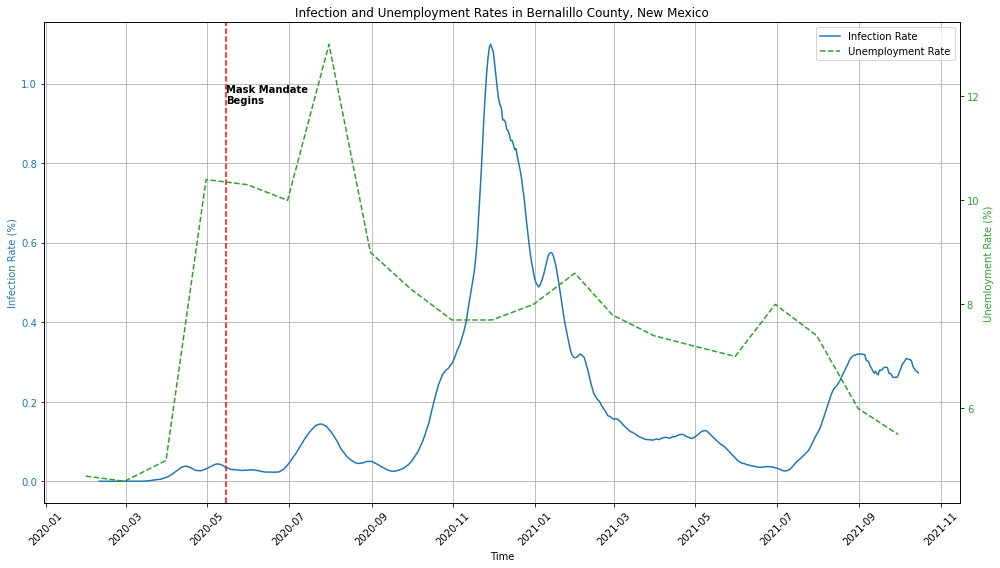

In [26]:
fig, ax1 = plt.subplots(figsize=(14,8))
color = "tab:blue"
lns1 = plt.plot(total_cases.date, total_cases.infection_rate*100, label="Infection Rate", color = color)
ax1.tick_params(axis='y', labelcolor=color)
plt.grid()
plt.xticks(total_cases.date[::60],  rotation=45)
plt.ylabel("Infection Rate (%)", color = color)
plt.xlabel("Time")
plt.title("Infection and Unemployment Rates in Bernalillo County, New Mexico")
plt.axvline(x=pd.to_datetime(mandate_date, format="%m/%d/%Y"), color='r', linestyle="--")
plt.text(pd.to_datetime(mandate_date, format="%m/%d/%Y"), .95, "Mask Mandate \nBegins", fontweight="bold")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Unemloyment Rate (%)', color=color)  # we already handled the x-label with ax1
lns2 = ax2.plot(pd.to_datetime(labor_df["time"]), labor_df["unemployment rate"], 
                color=color, linestyle="dashed", label="Unemployment Rate")
ax2.tick_params(axis='y', labelcolor=color)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
plt.legend(lns,labs,loc="upper right")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('../graph/uneployment', bbox_inches = 'tight')
plt.show()

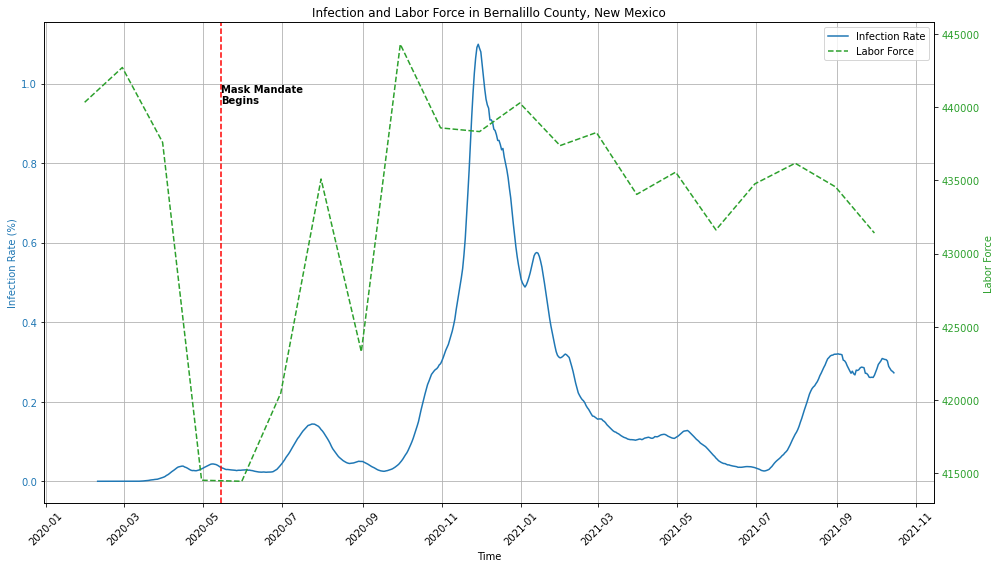

In [27]:
fig, ax1 = plt.subplots(figsize=(14,8))
color = "tab:blue"
lns1 = plt.plot(total_cases.date, total_cases.infection_rate*100, label="Infection Rate", color = color)
ax1.tick_params(axis='y', labelcolor=color)
plt.grid()
plt.xticks(total_cases.date[::60],  rotation=45)
plt.ylabel("Infection Rate (%)", color = color)
plt.xlabel("Time")
plt.title("Infection and Labor Force in Bernalillo County, New Mexico")
plt.axvline(x=pd.to_datetime(mandate_date, format="%m/%d/%Y"), color='r', linestyle="--")
plt.text(pd.to_datetime(mandate_date, format="%m/%d/%Y"), .95, "Mask Mandate \nBegins", fontweight="bold")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Labor Force', color=color)  # we already handled the x-label with ax1
lns2 = ax2.plot(pd.to_datetime(labor_df["time"]), labor_df["labor force"], 
                color=color, linestyle="dashed", label="Labor Force")
ax2.tick_params(axis='y', labelcolor=color)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
plt.legend(lns,labs,loc="upper right")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('../graph/labor_force', bbox_inches = 'tight')
plt.show()

In [28]:
df_test

,Year,Period,labor force,employment,unemployment,unemployment rate,time,unemployment_diff,labor_force_diff,covid_monthly_infection_diff
0,2020,Feb,442706,422131,20575,4.6,2020-02-29,-327.0,2374.0,0.0
1,2020,Mar,437598,415614,21984,5.0,2020-03-31,1409.0,-5108.0,82.0
2,2020,Apr,414535,371514,43021,10.4,2020-04-30,21037.0,-23063.0,553.0
3,2020,May,414464,371736,42728,10.3,2020-05-31,-293.0,-71.0,64.0
4,2020,Jun,420489,378337,42152,10.0,2020-06-30,-576.0,6025.0,-95.0
5,2020,Jul,435095,378360,56735,13.0,2020-07-31,14583.0,14606.0,1916.0
6,2020,Aug,423306,385129,38177,9.0,2020-08-31,-18558.0,-11789.0,-1325.0
7,2020,Sep,444293,407378,36915,8.3,2020-09-30,-1262.0,20987.0,-468.0
8,2020,Oct,438584,404787,33797,7.7,2020-10-31,-3118.0,-5709.0,3723.0
9,2020,Nov,438332,404466,33866,7.7,2020-11-30,69.0,-252.0,9673.0
